# Compute summary statistics of LST and NDVI

## Introduction

Having computed LST and NDVI in NYC, we compute summary statistics within HOLC grades. We compute the  

- mean
- median
- minimum
- maximum
- standard deviation
- number of clear pixels (The number of clear pixels is an integer representing the number of values in a HOLC boundary that are not `NaN`.)

of the LST and NDVI within every HOLC boundary and save the results to a CSV file. We do this for every clipped LST and NDVI file, ending up with a CSV containing summary statistics for each.

In a second iteration of this notebook, we found that it is advantageous to invoke a cloud filtering process to omit HOLC boundaries which are more than 10% covered by clouds. In [Section 2](#pixelnum) we reprocess the summary statistics data to add a column for the fraction of uncovered pixels called `pixel_frac`. We export these files to the same `summary_stats_agg/` folder with the prefix "ext_stats_lst_...", where the ellipses are in place of the original Landsat filename. 

We aggregate the summary statistics in several ways:

- [Method 1](#method1): For every summary statistic file, we compute the mean of each summary statistic grouped by HOLC grade. This results in four numbers, one for each HOLC grade, representing the mean of the median LST/NDVI for a specific Landsat scene. (We also have the mean of the minimum, mean of the maximum, etc.) We additionally group by NYC borough and compute the mean of each summary statistic, obtaining the mean of the median LST/NDVI for an HOLC grade within a specific borough. This means that for each summary statistic file we have 24 values: the mean of the summary statistics for each HOLC grade across NYC and for each HOLC grade across each borough. 
- [Method 2](#method2): Since we want a representative value for the LST/NDVI in an HOLC boundary over a decade, we first collect all of the Landsat scenes within a date range. We then calculate the mean of the median LST/NDVI of a single HOLC boundary within NYC by computing the mean of the median LST in that boundary for the set of scenes within a date range. We then take the mean of those means to obtain a value for the expected LST/NDVI in that decade. 
- [Method 3](#method3): Collect all the HOLC_X boundaries within a decade and calculate the mean of the median pixel to get the expected LST within a decade. This differs from Method 2 because we group all HOLC_X scenes within a decade, rather than grouping statistics for a single HOLC boundary first.
- [Method 4](#method4): Instead of taking the mean of median values as we did in Methods 1 through 3, we collect all of the summary statistics within a certain date range into four large files. By aggregating values in this way, we work more closely with the raw data. 

Details of all these methods are located within their respective sections. 

## Data

Two types of data are imported: (i) raster data, which comes from LST and NDVI computations obtained from Landsat and (ii) shapefiles specifying HOLC boundaries. All files are imported and exported from the `02-data/` directory. Shapefiles are imported from `boundaries/holc_nyc/` and LST/NDVI files are imported from `lst_clipped_nyc/`/`ndvi_clipped_nyc`.

Summary statistics are exported as CSV files to three different directories. First, summary statistics for every LST/NDVI file containing information for every HOLC boundary is exported to `summary_stats/`. The number of files in this folder should match the total sum of files in `lst_clipped_nyc/` and `ndvi_clipped_nyc/`. Then the results are aggregated and exported to `summary_stats_agg/` and `summary_stats_temporal/`.

| Description | Location | Data type | Naming convention | 
|--|-----|--|------|
| LST | `lst_clipped_nyc/` | TIF | "lst_**LANDSAT-IDENTIFIER**.TIF" |
| NDVI | `ndvi_clipped_nyc/` | TIF | "ndvi_**LANDSAT-IDENTIFIER**.TIF" |
| Summary statistics | `summary_stats` | CSV | "stats_lst_**LANDSAT-IDENTIFIER**.csv" and "stats_ndvi_**LANDSAT-IDENTIFIER**.csv" |
| Extended summary statistics | `summary_stats` | CSV | "ext_lst_stats_lst_**LANDSAT-IDENTIFIER**.csv" and "ext_ndvi_filt_ stats_lst_**LANDSAT-IDENTIFIER**.csv"|
| Aggregated summary statisitics | `summary_stats_agg` | CSV | `lst_mean_stats_combined` and `ndvi_mean_stats_combined`. |

**LANDSAT-IDENTIFIER** is the filename provided by the USGS, e.g.  "LC08_L1TP_013032_20140731_20170304_01_T1".


In [1]:
import os
DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_SCRIPTS = DIR_PARENT + "/01-scripts"

"""Push directory to helper scripts from"""
import sys
sys.path.append(DIR_SCRIPTS)

import helpers

import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# Import directories
DIR_DATA = DIR_PARENT + "/02-data"

DIR_STATS = DIR_DATA + "/summary_stats"
DIR_STATS_AGG = DIR_DATA + "/summary_stats_agg"
DIR_STATS_T = DIR_DATA + "/summary_stats_temporal"

DIR_BOUNDARIES = DIR_DATA + "/boundaries"
DIR_BOUNDARIES_HOLC = DIR_BOUNDARIES + "/holc_nyc"

# Export directories
DIR_NDVI_CLIPPED_NYC = DIR_PARENT + "/02-data/ndvi_clipped_nyc"
DIR_LST_CLIPPED_NYC = DIR_PARENT + "/02-data/lst_clipped_nyc"
DIR_FIGS = DIR_PARENT + "/03-figs"

keys_stats = ["median","mean","min","max","std","num_pixels"]

def compute_stats(clipped_file):
    """
    Compute the median, mean, min, max pixel for a clipped boundary.
    Additionally compute the standard deviation and the number of 
    non-NaN pixels. Return a dictionary.
    """
    stats = {"median": clipped_file.median().values,
            "mean": clipped_file.mean().values,
            "min": clipped_file.min().values,
            "max": clipped_file.max().values,
            "std": clipped_file.std().values,
            "num_pixels:": np.count_nonzero(~np.isnan(clipped_file))}
    return stats

def get_row_df(df, row_loc):
    """Get the row_loc'th row of a datafram. (Was having issues with
    .loc[], which is essentially what this does.)"""
    return df[df.index==row_loc]

def parse_date_fname(fname):
    """Parse the datetime from the summary statisics filename"""
    return pd.to_datetime(fname.split("_")[8])

def datetime_year(y): 
    """Make a datetime object from a given year"""
    return pd.to_datetime("1Jan"+str(y))

"""Get all the clipped LST and NDVI filenames
Calling get_filenames twice compiles all the filenames to one list."""
clipped_filenames = []
helpers.get_filenames(DIR_LST_CLIPPED_NYC, clipped_filenames)
helpers.get_filenames(DIR_NDVI_CLIPPED_NYC, clipped_filenames)

"""Get the CRS from landsat"""
crs_landsat = rxr.open_rasterio(clipped_filenames[0], 
                                masked=True).rio.crs

"""Get all filenames of HOLC shapefiles"""
shapefile_names_holc = []
helpers.get_filenames(DIR_BOUNDARIES_HOLC, shapefile_names_holc)
shapefile_names_holc = [x for x in shapefile_names_holc if ".shp" in x]

"""Initialize a dataframe to store all the HOLC information"""
df_holc = gpd.read_file(shapefile_names_holc[0])
df_holc = df_holc.to_crs(crs_landsat)
df_holc["loc_year"] = shapefile_names_holc[0].split("/")[-2]
print(shapefile_names_holc[0].split("/")[-2], ", ", len(df_holc))

"""Concatenate all the HOLC boundaries into a Dataframe."""
for fn in shapefile_names_holc[1:]:
    df = gpd.read_file(fn)
    df = df.to_crs(crs_landsat)
    boro_year = fn.split("/")[-2]
    df["loc_year"] = boro_year
    print(boro_year, ", Number of boundaries = ", len(df))
    df_holc = df_holc.append(df)

df_holc.reset_index(inplace=True)

"""Print the number of boundaries and the total area"""
print("\n")
for holc_grade in ["A","B","C","D"]:
    holc_geos = df_holc[df_holc["holc_grade"]==holc_grade]["geometry"]
    # Convert to a CRS that uses meters to measure area:
    holc_geos = holc_geos.to_crs(3857)
    tot_area = sum(holc_geos.apply(lambda x: x.area))
    print("Grade ", holc_grade, " has", sum(df_holc["holc_grade"]==holc_grade), 
         "boundaries and a total area of",tot_area/1000**2, "km^2")

print("\nNumber of LST and NDVI files = ",len(clipped_filenames))

NYStatenIsland1940 ,  66
NYManhattan1937 , Number of boundaries =  53
NYBronx1938 , Number of boundaries =  44
NYQueens1938 , Number of boundaries =  168
NYBrooklyn1938 , Number of boundaries =  66


Grade  A  has 16 boundaries and a total area of 18.630957718439234 km^2
Grade  B  has 72 boundaries and a total area of 120.48137553473349 km^2
Grade  C  has 189 boundaries and a total area of 389.53659708482655 km^2
Grade  D  has 119 boundaries and a total area of 223.57670025065053 km^2

Number of LST and NDVI files =  229


NYC has $~778$ km$^2$ of land.

In [20]:
df_holc[df_holc["holc_grade"]=="E"] # Not sure what this is 

,index,name,holc_id,holc_grade,geometry,loc_year
162,43,None,E1,E,"POLYGON ((596046.892 4522070.547, 596050.225 4...",NYBronx1938


## 1. Compute summary statistics for every HOLC file <a id="summary-calc"></a>

For every clipped LST/NDVI file, we clip to each HOLC boundary and save the summary statistics for every boundary as a row in a pandas dataframe. The exported file has the form outlined in the table below. 

| holc_id | holc_grade | geometry | loc_year | median | mean | min | max | std | num_pixels |
|---------|------------|----------|----------|--------|------|-----|-----|-----|-----|
| "boundary_id_from_source_file" | "holc_grade" | holc_polygon | "boro_identifier" | median_pixel | mean_pixel | min_pixel | max_pixel | std_pixel | num_pixels |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |$\vdots$ |$\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

**!! NOTE !!** The following cell takes a few hours to run. If you already have already computed statistics for every Landsat file, skip to the next cell. 

In [ ]:
"""
!!!
Only run the following loop if you don't already have summary statistics computed.
!!!
"""
for fn in clipped_filenames:
    
    """Initialize a DF for the HOLC data and summary statistics"""
    df_holc_stats = df_holc.copy()
    df_holc_stats[keys_stats] = 0.0

    for index in range(len(df_holc)):
        # For every HOLC polygon, clip the input data and compute 
        # statistic
        boundary_holc = get_row_df(df_holc,index)["geometry"]
        
        # Import the data that you will clip. This is either LST or NDVI data. 
        clipped = helpers.open_and_clip(fn, boundary_holc)

        # ! IMPORTANT ! All values equal to -9999.0 were masked by the 
        # USGS. Must mask the dataframe in order for statistics to be 
        # accurate.
        clipped_masked = clipped.where(clipped != -9999.0) 

        df_holc_stats.loc[index,keys_stats] = compute_stats(
                clipped_masked).values()
    
    exportname = DIR_STATS + "/stats_" + fn.split("/")[-1].split(".")[0] + ".csv"
    df_holc_stats = pd.DataFrame(df_holc_stats)
    print("Saving ",exportname)
    df_holc_stats.to_csv(exportname, index=False)    

### A. Inspecting Summary Statistics

Below we inspect the summary statistics further by plotting the LST or NDVI in a clipped HOLC boundary. We additionally plot a histogram of the distribution of the values within that boundary. 

In [3]:
# Get all the summary stats and split into NDVI and LST
lst_names = [x for x in clipped_filenames if "lst_L" in x \
                     and "ext" not in x]
ndvi_names = [x for x in clipped_filenames if "ndvi_L" in x \
                      and "ext" not in x]
lst_names.sort()
ndvi_names.sort()
print("Number of lst files = ", len(lst_names))
print("Number of ndvi files = ", len(ndvi_names))

Number of lst files =  114
Number of ndvi files =  114


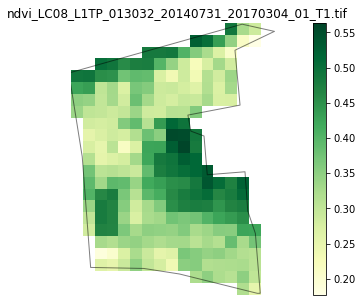

In [4]:
## USER INPUTS #####################################################################
obs_choice = 1 # OPTIONS: 0 for LST and 1 for NDVI
column_choice = "median" # OPTIONS: median, mean, min, max, std
boundary_index = 0
fn_index = 0 # Number between 0 and len(lst_names)-1
## END USER INPUTS #################################################################

clipping_boundary = get_row_df(df_holc,boundary_index)["geometry"]

"""Get the filename"""
fn = ndvi_names[fn_index]
if obs_choice==0: fn = lst_names[fn_index]

"""Import the file"""
clipped = helpers.open_and_clip(fn, clipping_boundary)
clipped_masked = clipped.where(clipped != -9999.0) 
    
"""Plot the boundary overlaid on the image"""
f, ax = plt.subplots(figsize=(10, 5))
if obs_choice==0:
    im = clipped_masked.plot.imshow(ax=ax, cmap="coolwarm")
else:
    clipped_masked.plot.imshow(ax=ax, cmap="YlGn")        
clipping_boundary.plot(ax=ax, alpha=.5,color="none", edgecolor="black")
ax.set(title=fn.split("/")[-1])
ax.set_axis_off()

# plt.savefig(DIR_FIGS + "/cloud-cover-example-holc-boundary.png", bbox_inches = "tight")

Plot a histogram of the raw pixel values

Mean =  0.36409116
Stdev =  0.08535006


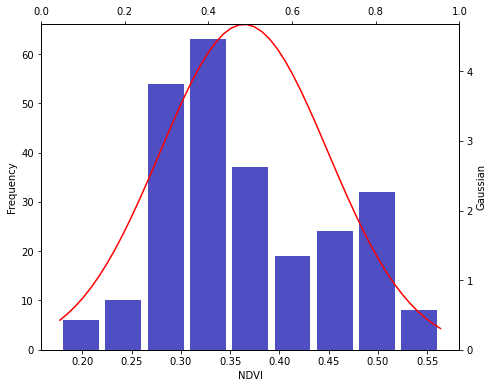

In [6]:
"""Must run the previous cell for this to work"""

###########################################################################
clipped_flattened = clipped_masked.stack(z=("x", "y")).to_dataframe(name="name")["name"].values
clipped_flattened = clipped_flattened[~np.isnan(clipped_flattened)]

data_to_test = clipped_flattened

fig, ax = plt.subplots(1,1, figsize=(7.5,6))

ax2 = ax.twinx()
ax3 = ax.twiny()

ax.hist(x=data_to_test, bins='auto', 
        color='#0504aa', alpha=0.7, rwidth=0.85)
if obs_choice==0:
    ax.set_xlabel("Temperature (K)")
else:
    ax.set_xlabel("NDVI")

ax.set_ylabel("Frequency")

"""Make Gasssian plot"""
avg_data = np.mean(data_to_test)
std_data = np.std(data_to_test)
xgauss = np.linspace(np.min(data_to_test),np.max(data_to_test),50)
ygauss = [(1/(std_data*np.sqrt(2*np.pi)))*np.exp(
            -(x-avg_data)**2/(2*std_data**2)) for x in xgauss]

"""Set the limits of the gaussian plot"""
ax2.set_ylim(ax2.get_ybound()[0], (1/(std_data*np.sqrt(2*np.pi)))+0.01)

ax2.plot(xgauss, ygauss, c="r")
ax2.set_ylabel("Gaussian")

print("Mean = ", avg_data)
print("Stdev = ", std_data)

### B. Find NaN values

We would like to know if any of the predicted summary statistics are NaN, and if so why. Below, we print the summary statistics filenames which contain NaN values, and then we plot the LST.

In [18]:
# Get all the summary stats and split into NDVI and LST
summary_names=[]
helpers.get_filenames(DIR_STATS, summary_names)
lst_summary_names = [x for x in summary_names if "lst" in x \
                     and "ext" not in x]
ndvi_summary_names = [x for x in summary_names if "ndvi" in x \
                      and "ext" not in x]

print("\nFilenames that contain nan median values")
fnames_nan = []
for fname in lst_summary_names:
    df_stats = pd.read_csv(fname)
    if pd.isna(df_stats["median"]).any():
        print(fname)
        fnames_nan.append(fname)


Filenames that contain nan median values
/home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LT05_L1TP_014032_19840921_20161004_01_T1.csv
/home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LT05_L1TP_014032_19890701_20161002_01_T1.csv
/home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LT05_L1TP_014032_19890903_20161002_01_T1.csv
/home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LT05_L1TP_014032_19950819_20160926_01_T1.csv
/home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LT05_L1TP_014032_19950904_20160926_01_T1.csv


### Print the NaN values in the DataFrames

In [7]:
fname_select = 1 # OPTIONS: Integer between 0 and 4

####################################################
df_stats = pd.read_csv(fnames_nan[fname_select])
df_nans = df_stats[pd.isna(df_stats["median"])]
print("Number of NaN values = ", len(df_nans))
df_nans

Number of NaN values =  1


,index,name,holc_id,holc_grade,geometry,loc_year,median,mean,min,max,std,num_pixels
317,154,NaN,D35,D,"POLYGON ((606758.6144636832 4494663.526147365,...",NYQueens1938,NaN,NaN,NaN,NaN,NaN,0.0


Plot the clipped Landsat scene for these boundaries.

Number of pixels =  0


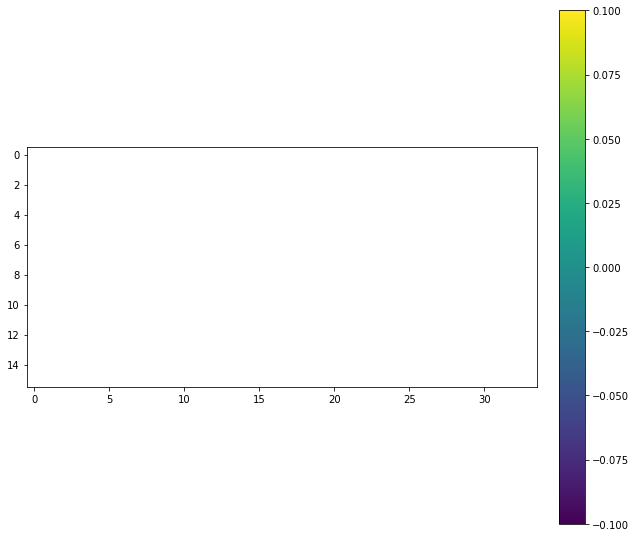

In [8]:
"""
Select one of the boundaries to clip to and plot
"""
select = 0 # OPTIONS: Integer between 0 and number of nan values-1

################################################################################
# Create the LST filename based on the summary statistics filename
landsat_id = fnames_nan[fname_select].split("lst_")[1][:-4]
# landsat_id = lst_summary_names[fname_select].split("lst_")[1][:-4]
fname_lst = DIR_LST_CLIPPED_NYC + "/lst_"+landsat_id+".tif"

# Get the HOLC ID of the boundaries which predict nan, then get the
# geometry object form the df_holc dataframe.
clipping_holc_id = df_nans.iloc[select]["holc_id"]
clipping_boundary = df_holc[df_holc["holc_id"]==clipping_holc_id]["geometry"]
clipped_lst = helpers.open_and_clip(fname_lst, clipping_boundary)
clipped_masked = clipped_lst.where(clipped_lst != -0.0) 
clipped_masked = clipped_masked.where(clipped_masked != -9999.0) 

print("Number of pixels = ", np.count_nonzero(~np.isnan(clipped_masked)))

fig, ax = plt.subplots(figsize = (10,10))
im = plt.imshow(clipped_masked)#, cmap="RdYlBu")#,vmin=-1,vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

These plots show that the NaN values are predicted when every pixel in a boundary is NaN. This motivates the measurement of the number of pixels involved in a LST/NDVI calculation. 

## 2. Append Cloud Cover Column  <a id="pixelnum"></a>

Even though we only use Landsat scenes that have less than 10% cloud cover, we see in the last few cells of the previous section that the cloud cover can entirely cover an HOLC boundary. For this reason, we append a column to the summary statistics called `pixel_frac` that represents the fraction of pixels in an HOLC boundary that are not covered by clouds. We implement a filter to compute statistics only using boundaries that have some minimum percentage of clear pixels. To create the `pixel_frac` column, we

1. Compute the maximum possible number of pixels in an HOLC boundary and saving the results to the `num_pixels_max` column of the dataframe `df_pixelnum`.
2. Compute `pixel_frac` = `num_pixels`/`num_pixels_max`. 
3. Append a column to the the summary statistics data frame for the `pixel_frac`.
4. Export an extended statistics file named "ext_**ORIGINAL-STATISTICS-FILENAME**". These files are saved to `summary_stats_agg`.

### A. Compute maximum number of pixels in an HOLC grade

(This takes a few minutes to complete.)

In [7]:
"""Initialize a dataframe to store the maximum pixel number"""
df_pixelnum = df_holc.copy()
df_pixelnum["num_pixels_max"] = 0.0

"""
Import an arbitrary LST file and set all its values to 1. This will
be used to clip and determine the maximum number of non-nan values
in a HOLC boundary.
"""
fn = clipped_filenames[0]
raster = rxr.open_rasterio(fn, masked=True)
rasterones = raster.where(type(raster)==float, 1.0).squeeze()

for index in range(len(df_holc)):
    # For every HOLC polygon, clip the raster of ones to the boundary
    # and compute the number of nonzero elements. 
    boundary_holc = get_row_df(df_holc,index)["geometry"]
    clipped = rasterones.rio.clip(boundary_holc).squeeze()
    df_pixelnum.loc[index,"num_pixels_max"] = np.count_nonzero(~np.isnan(clipped))

df_pixelnum

,index,name,holc_id,holc_grade,geometry,loc_year,num_pixels_max
0,0,Randall Manor,A1,A,"POLYGON ((576202.532 4499213.753, 576102.346 4...",NYStatenIsland1940,253.0
1,1,Grymes Hill,A2,A,"POLYGON ((576939.573 4496703.806, 576927.219 4...",NYStatenIsland1940,603.0
2,2,"Todt Hill, Emmerson Hill",A3,A,"POLYGON ((576032.804 4495907.753, 576293.388 4...",NYStatenIsland1940,2817.0
3,3,Silver Lake,A4,A,"POLYGON ((576070.303 4497876.449, 576092.302 4...",NYStatenIsland1940,235.0
4,4,West New Brighton,B1,B,"POLYGON ((574347.119 4497719.752, 574301.242 4...",NYStatenIsland1940,1124.0
...,...,...,...,...,...,...,...
392,61,None,D5,D,"POLYGON ((584855.656 4503598.365, 584611.342 4...",NYBrooklyn1938,1181.0
393,62,None,D6,D,"POLYGON ((585036.773 4505044.324, 585340.267 4...",NYBrooklyn1938,2912.0
394,63,None,D7,D,"POLYGON ((588420.333 4503600.212, 588338.791 4...",NYBrooklyn1938,1715.0
395,64,None,D8,D,"POLYGON ((591404.017 4503718.215, 591425.947 4...",NYBrooklyn1938,7402.0


### B. Compute `num_pixels`/`num_pixels_max` and export extended statistics

The extended statistics have the same structure as the summary statistics file described in Section 1 with the addition of a `pixel_frac` column. This column gives the fraction of pixels which are not covered. 

In [15]:
# Get all the summary stats names
summary_names=[]
helpers.get_filenames(DIR_STATS, summary_names)

# Make sure you're not importing the extended statistics, since those are
# saved to the same directory
summary_names = [x for x in summary_names if "ext" not in x and ".csv" in x]

for fn in summary_names:
    """
    For every summary statistics file, compute the pixel_frac of clear pixels
    and export a file called ext_.... This file contains the same information 
    as the original statistics file, but additionally contains pixel_frac.
    """
    df_summ = pd.read_csv(fn)
    df_summ["pixel_frac"] = df_summ["num_pixels"]/df_pixelnum["num_pixels_max"]
    exportname = DIR_STATS + "/ext_" + fn.split("/")[-1]
    df_summ.drop(columns="index")
    df_summ.to_csv(exportname, index=False)

## 3. Aggregate Statistics

We aggregate the summary statistics in several ways to analyze results temporally.

### A. Method 1: By Landsat File <a id=method1></a>

For LST and NDVI, we compile results into one aggregated dataframe in the following cell. The dataframe has the form 

| source_file | holc_grade | loc_year | median | mean | min | max | std | num_bounds |
|-------------|------------|----------|--------|------|-----|-----|-----|-----|
| "name_of_source_file"| "grade_to_filtery_by" | "boro_to_filter_by" | mean_of_medians | mean_of_mean | mean_of_min | mean_of_max | mean_of_std | num_boundaries |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |$\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

- `source_file` specifies the filename containing summary statistics for a single Landsat file. (These are the files exported in Section 1 of this notebook.) 
- `holc_grade` specifies the selected HOLC elements of `source_file` that are considered in the rest of the row
- `loc_year` specifies the selected location elements of `source_file` that are considered in the rest of the row
- `median`, `mean`, `min`, `max`, `std` are the means of the elements of `source_file` filtered by `holc_grade` and `loc_year`
- `num_bounds` is the number of boundaries used to compute the statistics. This may be less than the total number of HOLC boundaries for this grade if some of the boundaries in some scenes are filtered out due to low `pixel_frac`. 

For example, a few rows of the aggregate file that compute the summary statistics of LST in the Bronx may look like

| source_file | holc_grade | loc_year | median | mean | min | max | std |  num_bounds |
|-------------|------------|----------|--------|------|-----|-----|-----|-----|
| stats_lst_LT05_L1TP_014032_19910621_20160929_01_T1.csv | "A" | "NYBronx1938" | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |
| stats_lst_LT05_L1TP_014032_19910621_20160929_01_T1.csv | "B" | "NYBronx1938" | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |$\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

In this way, two aggregate files are generated: one for LST and one for NDVI. They are exported to `02-data/summary_stats_agg/`.



In [10]:
pixelfrac_filter = 0.9

###################################################################################
# Get all the summary stats and split into NDVI and LST
summary_names=[]
helpers.get_filenames(DIR_STATS, summary_names)
lst_summary_names = [x for x in summary_names if "lst" in x and "ext" in x]
ndvi_summary_names = [x for x in summary_names if "ndvi" in x and "ext" in x]

holc_grades = ["A","B","C","D"]
stat_cols = ["median","mean","min","max","std","pixel_frac"]
loc_years = ["NYBrooklyn1938","NYBronx1938","NYManhattan1937",
                 "NYStatenIsland1940","NYQueens1938"]

combined_filenames = [lst_summary_names, ndvi_summary_names]
prefix_filenames = ["ext_lst_filt"+str(pixelfrac_filter),
                    "ext_ndvi_filt"+str(pixelfrac_filter)]
count = 0
for filename_list in combined_filenames:
    
    df_all_stats = pd.DataFrame(columns=["source_file","holc_grade",
                        "loc_year","median","mean","min","max","std",
                        "pixel_frac", "num_bounds"])

    for filename in filename_list:

        df_stats = pd.read_csv(filename)
        
        """
        Filter for rows which have a num_pixels_frac greater than a 
        user-specified value
        """
        df_stats = df_stats[df_stats["pixel_frac"]>pixelfrac_filter]
        
        # Drop the HOLC Grade E row
        df_stats = df_stats[df_stats["holc_grade"]!="E"]

        # Compute the mean of all the summary statistics by HOLC grade
        # city-wide.
        mean_vals_nyc = df_stats.groupby("holc_grade").mean()[stat_cols]
        mean_vals_nyc["source_file"] = filename.split("/")[-1]
        mean_vals_nyc["loc_year"] = "NYC"
        mean_vals_nyc["num_bounds"] = df_stats.groupby("holc_grade").count()["index"]
        
        mean_vals_nyc.reset_index(inplace=True)

        df_all_stats = pd.concat([df_all_stats, mean_vals_nyc])

        for grade in holc_grades:
            # Compute the mean of all the summary statistics by HOLC 
            # grade by borough.
            mean_vals_boros = df_stats[df_stats["holc_grade"]==
                            grade].groupby("loc_year").mean()[stat_cols]
            mean_vals_boros["source_file"] = filename.split("/")[-1]
            mean_vals_boros["holc_grade"] = grade
            mean_vals_boros["num_bounds"] = df_stats[df_stats["holc_grade"]==
                            grade].groupby("loc_year").count()["index"]
            
            mean_vals_boros.reset_index(inplace=True)

            df_all_stats = pd.concat([df_all_stats, mean_vals_boros])

    df_all_stats.to_csv(DIR_STATS_T + "/m1_"+prefix_filenames[count]+
                        ".csv", index=False)
    count+=1

Look at the summary files more closely

In [25]:
summary_names=[]
helpers.get_filenames(DIR_STATS_AGG, summary_names)

fname = summary_names[-2]

df_stats = pd.read_csv(fname)

print("Number of elements with HOLC A = ", len(df_stats[df_stats["holc_grade"]=="A"]))
print("Number of elements with HOLC B = ", len(df_stats[df_stats["holc_grade"]=="B"]))
print("Number of elements with HOLC C = ", len(df_stats[df_stats["holc_grade"]=="C"]))
print("Number of elements with HOLC D = ", len(df_stats[df_stats["holc_grade"]=="D"]))

Number of elements with HOLC A =  678
Number of elements with HOLC B =  678
Number of elements with HOLC C =  678
Number of elements with HOLC D =  678


### B. Aggregate statistics Method 2: Group HOLC Boundary by Decade <a id=method2></a>

We want to know the mean of the median LST (NDVI) for $\sim$10 year periods. This suggests that we should compute the average median value of a specific HOLC boundary over that time period so we have a value which represents the expected temperature in that area. We save the result to a row in a dataframe. Repeating this for every time period that we consider, we end up with four files. Each file contains: 

| source_file | holc_grade | loc_year | median | mean | min | max | std | num_scenes |
|-------------|------------|----------|--------|------|-----|-----|-----|-----|
| "name_of_source_file"| "grade_to_filtery_by" | "boro_to_filter_by" | mean_of_medians | mean_of_mean | mean_of_min | mean_of_max | mean_of_std | num_scenes |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |$\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

- `source_file` specifies the filename containing summary statistics for a single Landsat file. (These are the files exported in Section 1 of this notebook.) 
- `holc_grade` specifies the selected HOLC elements of `source_file` that are considered in the rest of the row
- `loc_year` specifies the selected location elements of `source_file` that are considered in the rest of the row
- `median`, `mean`, `min`, `max`, `std` are the means of the elements of `source_file` filtered by `holc_grade` and `loc_year`
- `num_scenes` is the number of number of Landsat scenes used to compute the statistic. This may be less than the total number of scenes if there is a cloud over the boundary during one flyover. 

First, import all the filenames for the extended statistics and group them into the decades we consider. 

In [25]:
# The year ranges we choose for grouping the data
year_ranges = [(1984,1993), (1994,2002), (2003, 2012), (2013,2022)]

# fnames_stats is a list of all the extended filenames that we will use
fnames_stats = []
helpers.get_filenames(DIR_STATS, fnames_stats)
fnames_stats_lst = [x for x in fnames_stats if "lst" in x and "ext" in x]
fnames_stats_ndvi = [x for x in fnames_stats if "ndvi" in x and "ext" in x]

In [26]:
pixelfrac_filter = 0.0 # OPTIONS: Any float >0.0 and <1.0

#####################################################################

obs_options = ["lst","ndvi"]
for obs_choice in range(2):
    
    fnames = [fnames_stats_lst, fnames_stats_ndvi][obs_choice]
    fnames_yr = [
        [x for x in fnames if 
             parse_date_fname(x) <= datetime_year(year_ranges[yr][1]) and
             parse_date_fname(x) >= datetime_year(year_ranges[yr][0])] for yr in range(4)]
    
    for yr in range(4):
        label = obs_options[obs_choice]

        """Initialize a dataframe to store all the statistics information"""
        df_stats = pd.read_csv(fnames_yr[yr][0])
        df_stats["index"] = df_stats.index

        for i in range(1,len(fnames_yr[yr])):
            df_yr = pd.read_csv(fnames_yr[yr][i])
            df_yr["index"] = df_yr.index
            df_stats = pd.concat([df_stats, df_yr])

        df_filtered = df_stats[df_stats["pixel_frac"]>pixelfrac_filter]    

        """Compute the mean value for each HOLC boundary"""
        df_mean_stats = df_filtered.groupby("index").mean()
        df_mean_stats["num_bounds"] = df_filtered.groupby("index").count()["pixel_frac"]

        df_mean_stats["holc_grade"] = df_yr["holc_grade"]
        df_mean_stats["loc_year"] = df_yr["loc_year"]
        df_mean_stats["geometry"] = df_yr["geometry"]

        df_mean_stats.rename(columns={"pixelnum":"num_pixels",
                                      "pixelnum_max":"max_num_pixels"}, inplace=True)

        exportname = DIR_STATS_T + "/m2_ext_"+label+"_pfilt"+str(pixelfrac_filter)+\
                    "_yr"+str(yr)+".csv"
        df_mean_stats.to_csv(exportname, index=False)

### C. Aggregate statistics Method 3: Group All HOLC_X Boundaries within a Decade <a id=method3></a>

The two ways that we aggregate statistics temporally involve choosing an order in which to take the mean first--either first take the mean for a Landsat scene, or first take the mean for an HOLC boundary. We can avoid this problem if we take the mean of all HOLC_X boundaries within a certain time period. This way, there is no ambiguity about the first choice being made. We save the result to a row in a dataframe. Repeating this for every time period that we consider, we end up with one dataframe that contains `num_holc_grades` $\times$ `num_year_ranges` $=16$ rows. Each row contains the mean of the summary statistics for every HOLC boundary within that date range.  

| year_range | holc_grade | loc_year | median | mean | min | max | std | num_bounds |
|------------|------------|----------|--------|------|-----|-----|-----|-----|
| "year_range" | "grade_to_filtery_by" | "boro_to_filter_by" | mean_of_medians | mean_of_mean | mean_of_min | mean_of_max | mean_of_std | num_scenes |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |$\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

- `year_range` is a string representing the start and end range of the years. Both ends of the range are inclusive.
- `holc_grade` specifies the selected HOLC elements of `source_file` that are considered in the rest of the row
- `loc_year` specifies the selected location elements of `source_file` that are considered in the rest of the row
- `median`, `mean`, `min`, `max`, `std` are the means of the elements of `source_file` filtered by `holc_grade` and `loc_year`
- `num_scenes` is the number of number of Landsat scenes used to compute the statistic. This may be less than the total number of scenes if there is a cloud over the boundary during one flyover. 

First, import all the filenames for the extended statistics and group them into the decades we consider. 

In [27]:
# The year ranges we choose for grouping the data
year_ranges = [(1984,1993), (1994,2002), (2003, 2012), (2013,2022)]

# fnames_stats is a list of all the extended filenames that we will use
fnames_stats = []
helpers.get_filenames(DIR_STATS, fnames_stats)
fnames_stats_lst = [x for x in fnames_stats if "lst" in x and "ext" in x]
fnames_stats_ndvi = [x for x in fnames_stats if "ndvi" in x and "ext" in x]

In [28]:
pixelfrac_filter = 0.0 # OPTIONS: Any float >0.0 and <1.0
#####################################################################

obs_options = ["lst","ndvi"]
for obs_choice in range(len(obs_options)):
    
    fnames = [fnames_stats_lst, fnames_stats_ndvi][obs_choice]
    fnames_yr = [
        [x for x in fnames if 
             parse_date_fname(x) <= datetime_year(year_ranges[yr][1]) and
             parse_date_fname(x) >= datetime_year(year_ranges[yr][0])] for yr in range(4)]
    
    for yr in range(4):
        
        """Initialize a dataframe to store all the statistics information"""
        df_stats = pd.DataFrame(columns=["median", "mean", "min", "max", "std", "num_pixels", 
                "pixel_frac", "num_bounds", "year_range"])
        df_mean_stats = df_stats
        
        label = obs_options[obs_choice]

        for i in range(len(fnames_yr[yr])):
            df_yr = pd.read_csv(fnames_yr[yr][i])
            df_yr["index"] = df_yr.index
            df_stats = pd.concat([df_stats, df_yr])

        """Filter for the fraction of non-nan pixels"""
        df_filtered = df_stats[df_stats["pixel_frac"]>pixelfrac_filter]    

        """Compute the mean value for each HOLC boundary"""
        df_stats = df_filtered.groupby("holc_grade").mean()
        
        df_stats["num_bounds"] = df_filtered.groupby("holc_grade").count()["index"]
        df_stats["year_range"] = str(year_ranges[yr][0])+"-"+str(year_ranges[yr][1])
        
        df_mean_stats = pd.concat([df_mean_stats, df_stats])
        
        df_mean_stats.drop(columns="index", inplace=True)
        df_mean_stats.reset_index(inplace=True)
        df_mean_stats.rename(columns={"index":"holc_grade"}, inplace=True)

        exportname = DIR_STATS_T + "/m3_ext_"+label+\
                "_pfilt"+str(pixelfrac_filter)+"_yr"+str(yr)+".csv"
        df_mean_stats.to_csv(exportname)


### D. Aggregate statistics Method 4: Group Raw Data by Year Range <a id=method4></a>

Instead of taking the mean of the medians, group all the raw statistics data within a decade and include a column for the decade considered. In this way, we output one large `CSV` file for LST and another for NDVI.

| holc_id | holc_grade | geometry | loc_year | median | mean | min | max | std | num_pixels | year_range |
|---------|------------|----------|----------|--------|------|-----|-----|-----|-----|-----|
| "boundary_id_from_source_file" | "holc_grade" | holc_polygon | "boro_identifier" | median_pixel | mean_pixel | min_pixel | max_pixel | std_pixel | num_pixels | year_range |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |$\vdots$ |$\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

First, import all the filenames for the extended statistics and group them into the decades we consider. 

In [29]:
# The year ranges we choose for grouping the data
year_ranges = [(1984,1993), (1994,2002), (2003, 2012), (2013,2022)]

# fnames_stats is a list of all the extended filenames that we will use
fnames_stats = []
helpers.get_filenames(DIR_STATS, fnames_stats)
fnames_stats_lst = [x for x in fnames_stats if "lst" in x and "ext" in x]
fnames_stats_ndvi = [x for x in fnames_stats if "ndvi" in x and "ext" in x]

In [30]:
pixelfrac_filter = 0.0 # OPTIONS: Any float >0.0 and <1.0
#####################################################################

obs_options = ["lst","ndvi"]

for obs_choice in range(len(obs_options)):
    
    fnames = [fnames_stats_lst, fnames_stats_ndvi][obs_choice]
    fnames_yr = [
        [x for x in fnames if 
             parse_date_fname(x) <= datetime_year(year_ranges[yr][1]) and
             parse_date_fname(x) >= datetime_year(year_ranges[yr][0])] for yr in range(4)]

    for yr in range(4):
        """Initialize a dataframe to store all the statistics information"""
        df_stats = pd.DataFrame(columns=["landsat_id","median", "mean", "min", "max", "std", "num_pixels", 
                "pixel_frac", "year_range"])
        df_mean_stats = df_stats
        
        label = obs_options[obs_choice]

        for i in range(len(fnames_yr[yr])):
            df_yr = pd.read_csv(fnames_yr[yr][i])
            df_yr["index"] = df_yr.index
            df_yr["landsat_id"] = fnames_yr[yr][i].split("/")[-1].split(label)[1][1:-4]
            df_stats = pd.concat([df_stats, df_yr])

        """Filter for the fraction of non-nan pixels"""
        df_filtered = df_stats[df_stats["pixel_frac"]>pixelfrac_filter].copy()

        """Add year range column"""
        df_filtered["year_range"] = str(year_ranges[yr][0])+"-"+str(year_ranges[yr][1])
        
        df_mean_stats = pd.concat([df_mean_stats, df_filtered])
        df_mean_stats.drop(columns=["index"])

        exportname = DIR_STATS_T + "/m4_ext_"+label+\
                "_pfilt"+str(pixelfrac_filter)+"_yr"+str(yr)+".csv"
        df_mean_stats.to_csv(exportname, index=False)